## Restaurant Tip Prediction

data source: https://www.kaggle.com/datasets/jsphyg/tipping

Given data about *transactions* at a restaurant, let's try to predict the tip of a given customer will leave.

We will use a linear regression model to make our predictions. 

### Getting started

In [57]:
!pip install seaborn

In [58]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

In [59]:
data = pd.read_csv('tips.csv')
data

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


### Preprocessing

In [61]:
def preprocess_inputs(df):
    df = df.copy()

    # Binary encoding
    df['sex'] = df['sex'].replace({'Female':0, 'Male':1})
    df['smoker'] = df['smoker'].replace({'No':0, 'Yes':1})
    df['time'] = df['time'].replace({'Lunch':0, 'Dinner':1})

    # Ordinal Encoding
    df['day'] = df['day'].replace({'Thur': 0, 'Fri':1, 'Sat': 2, 'Sun': 3})
    
    return df

In [62]:
X = preprocess_inputs(data)
X

/tmp/ipykernel_9966/1689407950.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female':0, 'Male':1})
/tmp/ipykernel_9966/1689407950.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['smoker'] = df['smoker'].replace({'No':0, 'Yes':1})
/tmp/ipykernel_9966/1689407950.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `p

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,3,1,2
1,10.34,1.66,1,0,3,1,3
2,21.01,3.50,1,0,3,1,3
3,23.68,3.31,1,0,3,1,2
4,24.59,3.61,0,0,3,1,4
...,...,...,...,...,...,...,...
239,29.03,5.92,1,0,2,1,3
240,27.18,2.00,0,1,2,1,2
241,22.67,2.00,1,1,2,1,2
242,17.82,1.75,1,0,2,1,2


### Exploratory Data Analysis

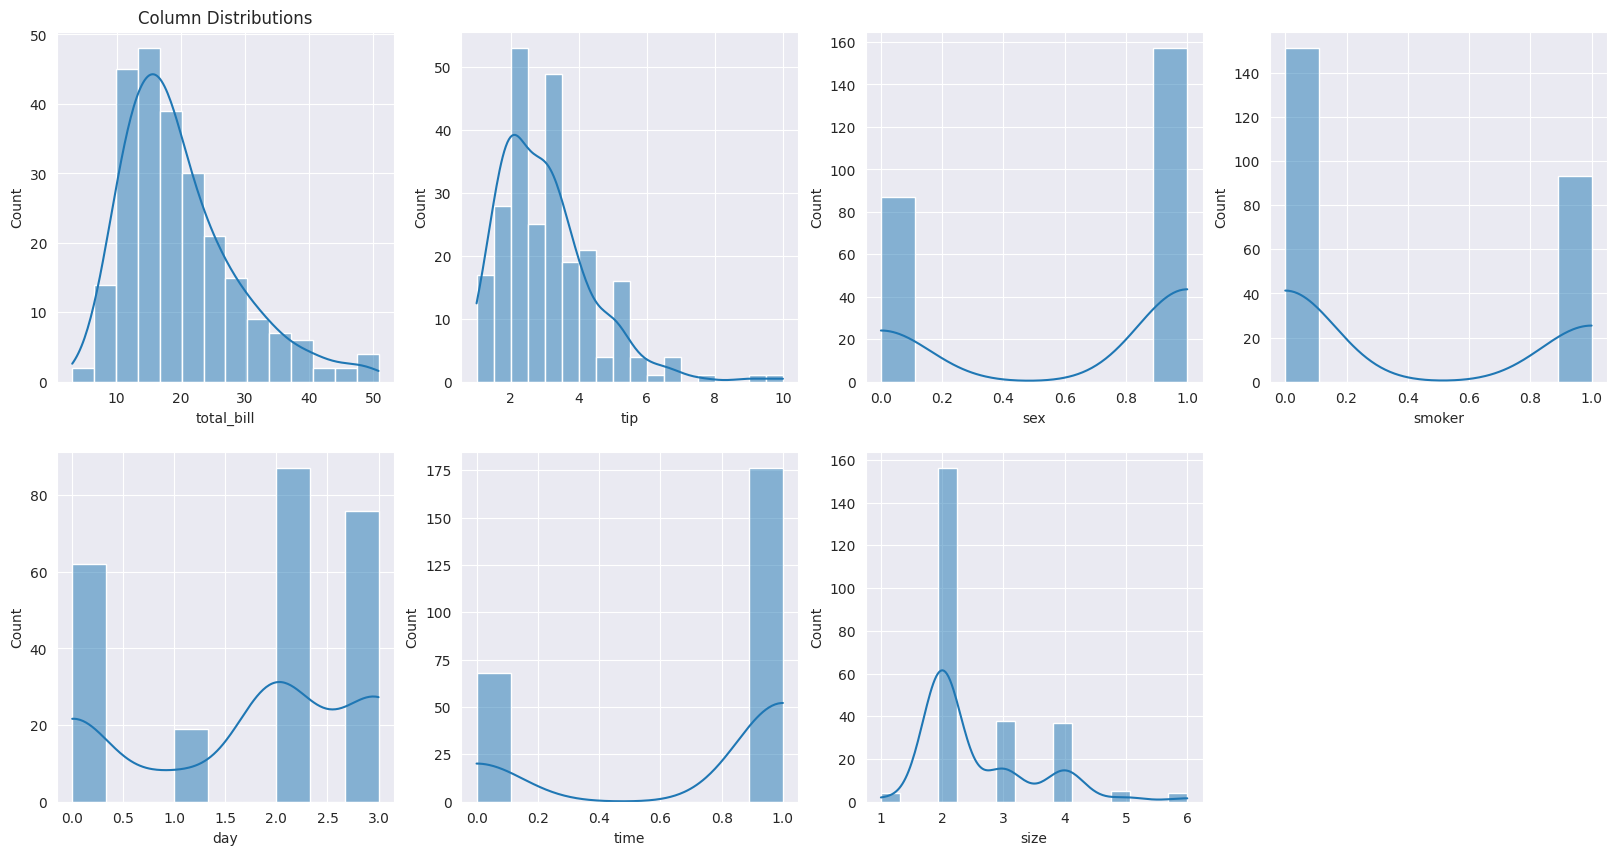

In [63]:
plt.figure(figsize=(20,10))

for i in range(len(X.columns)):
    plt.subplot(2, 4, i+1)
    if len(X[X.columns[i]].unique() > 2):
        sns.histplot(X[X.columns[i]], kde=True)
    else:
        sns.histplot(X[X.columns[i]], kde=False)
    if i == 0:
        plt.title("Column Distributions")
plt.show()

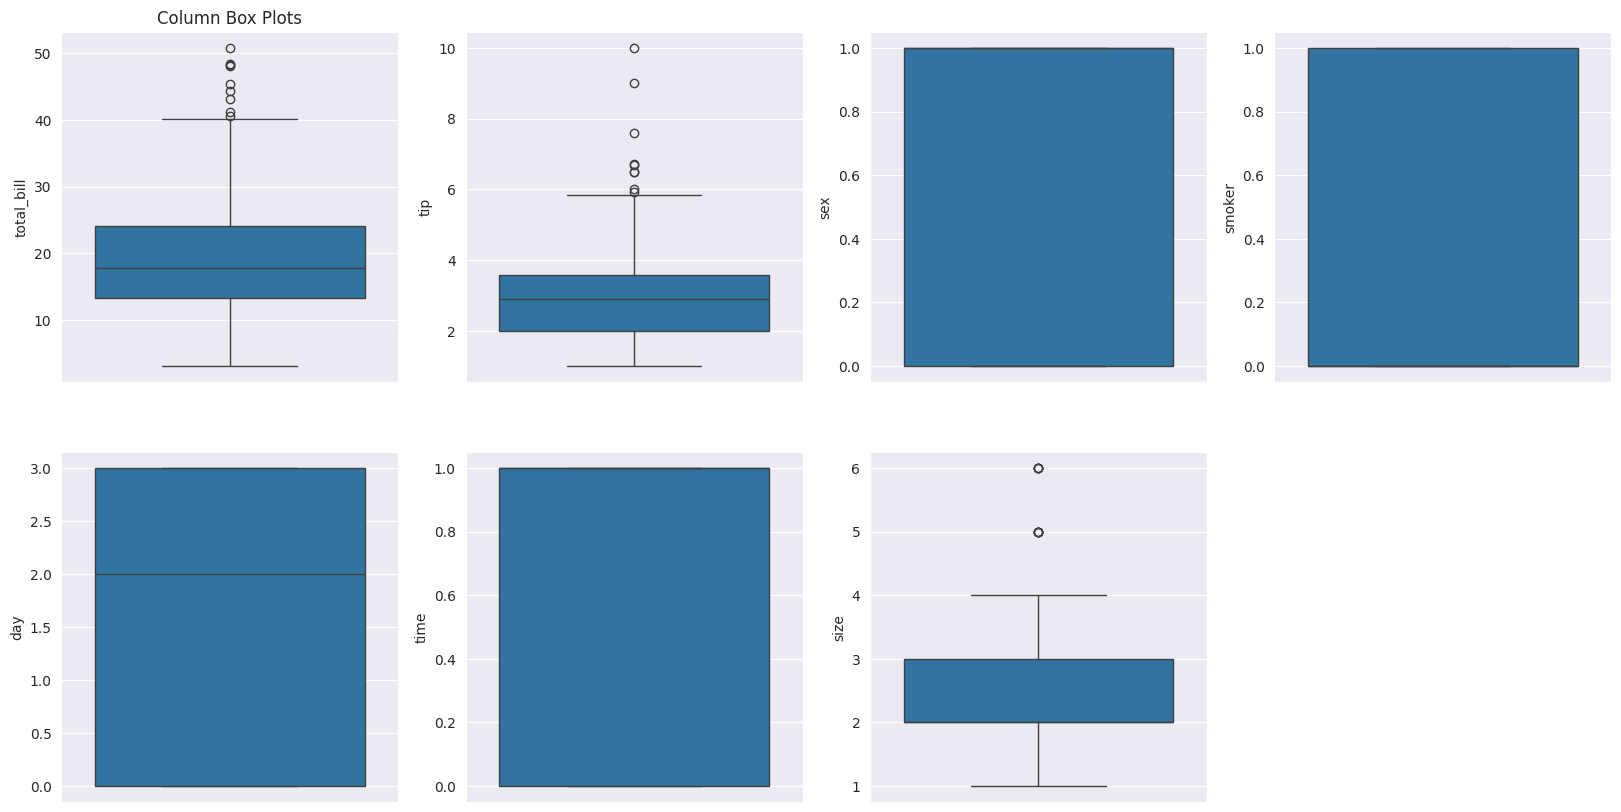

In [64]:
plt.figure(figsize=(20,10))

for i in range(len(X.columns)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(X[X.columns[i]])
    if i == 0:
        plt.title("Column Box Plots")
plt.show()

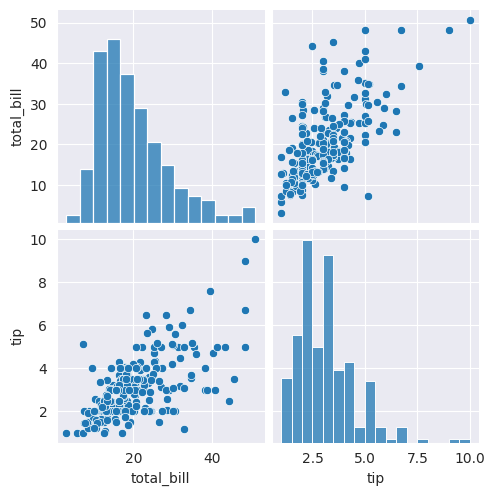

In [65]:
sns.pairplot(X.loc[:, ['total_bill', 'tip']])

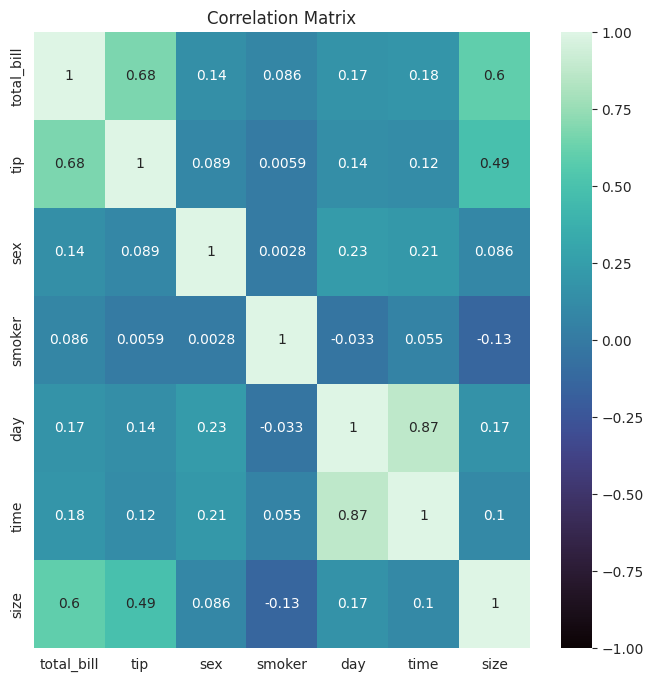

In [66]:
plt.figure(figsize=(8,8))
sns.heatmap(X.corr(), annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Matrix')
plt.show()

### Training

In [67]:
X = X.sample(frac=1.0, random_state=1).reset_index(drop=True)

In [68]:
y = X['tip']
X = X.drop('tip', axis=1)

In [69]:
X

,total_bill,sex,smoker,day,time,size
0,3.07,0,1,2,1,1
1,18.78,0,0,0,1,2
2,26.59,1,1,2,1,3
3,14.26,1,0,0,0,2
4,21.16,1,0,0,0,2
...,...,...,...,...,...,...
239,14.15,0,0,0,0,2
240,26.86,0,1,2,1,2
241,17.47,0,0,0,0,2
242,10.07,1,0,2,1,2


In [70]:
results = []
kf = KFold(n_splits=5)

for train_idx, test_idx in kf.split(X):
    X_train = X.iloc[train_idx, :] 
    X_test = X.iloc[test_idx, :] 
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    model = LinearRegression()
    model.fit(X_train, y_train)

    results.append(model.score(X_test, y_test))

In [71]:
results

[0.49755299573499756,
 -0.12223894713164984,
 0.3551720639479413,
 0.5701460117958316,
 0.5492734419211261]

### Results

In [72]:
for i in range(len(results)):
    print("Fold {}: {:.5f}".format(i + 1, results[i]))
print("\nAverage R^2 Score: {:.5f}".format(np.mean(results)))

Fold 1: 0.49755
Fold 2: -0.12224
Fold 3: 0.35517
Fold 4: 0.57015
Fold 5: 0.54927

Average R^2 Score: 0.36998
